# Non-stationary [SCM-MAB](https://papers.nips.cc/paper/2018/hash/c0a271bc0ecb776a094786474322cb82-Abstract.html)

- Need to allow for prior on causal effects (--> Bayesian MAB)
- Non-stationary Bayesian structural causal MAB
    - Non-stationary because the reward statistics changes across time
    - Bayesian because we have a prior on the reward distribution
    - Structural because we are aware of the causal structure of the reward distribution 

## Stationarity assumptions of standard MAB algorithms

- Thompson Sampling (Thompson, 1933), UCB and epsilon-greedy assume that the rewards are i.i.d. samples from stationary distributions (Allesiardo et al., 2017), thus are not suitable for the (DBN-like underyling CGM) application.
- The EXP3 (Auer et al., 2002b) MAB algorithm makes comparatively fewer assumptions on reward distributions and can deal with the general setting of adversarially-defined rewards. The general adversarial bandit setting is important for our application as it enables the MAB to handle the non-stationary nature of the rewards observed during the optimisation (Allesiardo et al., 2017).

## Considerations

- Appears to be a so-called 'restless bandit problem'
- _Sometimes_ we have observational data, so we have a strong prior on the reward distribution
- We are doing inference on the reward distribution (exploring it) whilst playing the game, this means we are dealing with NS-MAB.
- At the start of the game, all we have is a prior on the reward distribution (one for each exploration set) but as we play the game, we collect more observations, update our prior, and then continue the game until we find the best arm. 
    - **CONTINUOUS CAUSAL EFFECTS** As we play the game, BO will tell us _where_ on the selected arm to explore

In [21]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append("..")
sys.path.append("../src")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.utils.dag_utils.graph_functions import make_graphical_model, make_networkx_object, get_time_slice_sub_graphs, make_time_slice_causal_diagrams

In [3]:
from npsem.utils import subseq
from npsem.NIPS2018POMIS_exp.scm_examples import IV_SCM
from npsem.scm_bandits import SCM_to_bandit_machine, arms_of 
from npsem.bandits import play_bandits
from itertools import product

# Non-stationary SCM-MAB as piece-wise stationary SCM-MAB 

SCM-MAB will be run on the DAG in each time-slice (which could change across time). The reward distribution will change as we step through the graph, from left to right.

- We start with a DAG in which the connectivity is the same across time and then add complexity when it works.

In [39]:
node_info = {"Z": {"type": "manipulative", "domain": (0,1)},
             "X": {"type": "manipulative", "domain": (0,1)},
             "Y": {"type": "manipulative", "domain": (-1,1)}}
            #  "U" : {"type": "confounder"}}
# Constructor for adding unobserved confounder to graph
# XXX: this construction allows us to model situations in which confounding varibles appear and disappear across time-steps
conf_info = {0: ("X","Y"), 1:  ("X","Y"), 2:  ("X","Y")}

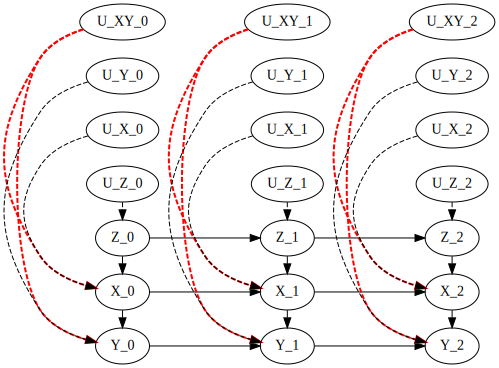

In [40]:
T = 3
graph_view = make_graphical_model(0,
T-1,
topology='dependent',
target_node='Y',
node_information= node_info,
confounder_info=conf_info,
verbose=True)
graph_view

In [48]:
background_info = {
    # Exogenous / background conditions
    "U_Z": {"type": "background", "domain": (0, 1)},
    "U_X": {"type": "background", "domain": (0, 1)},
    "U_Y": {"type": "background", "domain": (0, 1)},
    "U_XY": {"type": "confounder", "domain": (0, 1)},
}
# Contains all the sub-graphs per time-slice
G = make_networkx_object(graph_view, node_info | background_info, T)
# TODO: need to add assigned variable edges here but make sure that they are removed from the relevant node if that variable is intervened upon.
gs = get_time_slice_sub_graphs(G,T)
cds = make_time_slice_causal_diagrams(gs,conf_info)

0 


{'X', 'Y', 'Z'}
[('Z', 'X'), ('X', 'Y')]
[('X', 'Y', 'U_XY')]
1 


{'X', 'Y', 'Z'}
[('X', 'Y'), ('Z', 'X')]
[('X', 'Y', 'U_XY')]
2 


{'X', 'Y', 'Z'}
[('X', 'Y'), ('Z', 'X')]
[('X', 'Y', 'U_XY')]


In [64]:
mu = (0.4454, 0.493, 0.5070000000000001, 0.773, 0.22700000000000004, 0.493, 0.493, 0.5070000000000001, 0.5070000000000001)
mu_star = np.max(mu) 
arm_played = [0, 3, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0]

In [67]:
np.mean(compute_optimality(arm_played, mu), axis=0)

0.14285714285714285

In [73]:
test = dict(zip(np.array([1, 2, 3, 4]), np.array([ 1965,  1907, 95386,   742])))
test

{1: 1965, 2: 1907, 3: 95386, 4: 742}

In [72]:
max(test, key = test.get)

3

In [74]:
arm_setting[3]

NameError: name 'arm_setting' is not defined

## Explore SCM from fig 3

In [22]:
from scipy.stats import bernoulli as ber
from src.examples.SEMs import DynamicIVCD
from itertools import product
from collections import defaultdict
from npsem.model import default_P_U
from npsem.utils import combinations
from src.utils.sampling import sample_sem

In [23]:
SEM = DynamicIVCD()
static = SEM.static()
dynamic = SEM.dynamic()

# SEM = DynamicIVCD()
# static = SEM.static()
# dynamic = SEM.dynamic(clamped={"X":0, 'Z':1, "Y":1})
T = 3
N = 4 
exo_vars = {"U_Z": ber.rvs(p=0.6, size=(N,T)), "U_X":ber.rvs(p=0.11, size=(N,T)), "U_Y":ber.rvs(p=0.15, size=(N,T)) ,"U_XY":ber.rvs(p=0.51, size=(N,T))}
# epsilon = np.random.randint(2, size=(N,T))
sem_samples  = {k:np.empty((N,T), dtype='int') for k in static.keys()}
sem_samples
samples = sem_samples | exo_vars
samples

{'Z': array([[0, 0, 1],
        [0, 0, 0],
        [1, 1, 1],
        [1, 0, 1]]),
 'X': array([[0, 0, 1],
        [0, 0, 0],
        [1, 1, 1],
        [1, 0, 1]]),
 'Y': array([[-2305843009213693952, -2305843009213693952,                    7],
        [                   0,         450971566080,  3904177109877286251],
        [ 3269951112431679028,  3487250855172059705,  4048001806913580388],
        [ 3474639491177658416,  8386112019185545529,  4063427954953319285]]),
 'U_Z': array([[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1],
        [1, 0, 1]]),
 'U_X': array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 'U_Y': array([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]),
 'U_XY': array([[0, 0, 1],
        [0, 0, 0],
        [1, 1, 1],
        [1, 0, 1]])}

In [173]:
num_trial =1
horizon = 20
n_jobs = 2
Y = "Y"

In [174]:
M, p_u = IV_SCM(devised=True,seed=0)
mu, arm_setting = SCM_to_bandit_machine(M)

In [175]:
arm_setting

{0: {},
 1: {'X': 0},
 2: {'X': 1},
 3: {'Z': 0},
 4: {'Z': 1},
 5: {'X': 0, 'Z': 0},
 6: {'X': 0, 'Z': 1},
 7: {'X': 1, 'Z': 0},
 8: {'X': 1, 'Z': 1}}

In [176]:
arm_strategy = 'Brute-force'
bandit_algo = 'TS'
arm_selected = arms_of(arm_strategy, arm_setting, M.G, Y)
arm_corrector = np.vectorize(lambda x: arm_selected[x])

In [178]:
arm_corrector

In [127]:
arm_played, rewards = play_bandits(horizon, subseq(mu, arm_selected), bandit_algo, num_trial, n_jobs)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.8s finished


In [130]:
results = dict()
results[(arm_strategy, bandit_algo)] = arm_corrector(arm_played), rewards

In [133]:
arm_selected

(0, 1, 2, 3, 4, 5, 6, 7, 8)

In [134]:
results

{('Brute-force',
  'TS'): (array([[4, 5, 6, 0, 3, 3, 3, 7, 3, 8, 3, 8, 3, 8, 3, 3, 2, 6, 5, 3]]), array([[0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
          1., 0., 0., 0.]]))}

# Test Non-Stationary (piece-wise stationary) SCM-MAB

In [70]:
from src.examples.example_setup import setup_DynamicIVCD
from nsscmmab import NSSCMMAB
from npsem.model import StructuralCausalModel as SCM

In [73]:
params = setup_DynamicIVCD()
params

{'G': <networkx.classes.multidigraph.MultiDiGraph at 0x7f83a0fa6880>,
 'SEM': src.examples.struct_eq_models.DynamicIVCD,
 'mu1': {'U_X': 0.11, 'U_Y': 0.15, 'U_Z': 0.6, 'U_XY': 0.51},
 'node_info': {'Z': {'type': 'manipulative', 'domain': (0, 1)},
  'X': {'type': 'manipulative', 'domain': (0, 1)},
  'Y': {'type': 'manipulative', 'domain': (-1, 1)},
  'U': {'type': 'confounder', 'domain': None}},
 'confounder_info': {0: ('X', 'Y'), 1: ('X', 'Y'), 2: ('X', 'Y')},
 'base_target_variable': 'Y',
 'horizon': 10,
 'n_trials': 2,
 'n_jobs': 2}

In [72]:
domains = {key: val["domain"] for key, val in params["node_info"].items()}

In [75]:
out = SCM(
    temporal_index=0,
    G=cds[0],
    F=params["SEM"].static(),
    P_U=default_P_U(params["mu1"]),
    D=domains,
    more_U={"U_{}".format(v) for v in cds[0].V}
)

In [77]:
 U = list(sorted(out.G.U | out.more_U))
 U

['U_0', 'U_X', 'U_Y', 'U_Z']

In [82]:
cds[0].U

frozenset({'U_0'})

Compare my version of the domain vs. the defaultdict version

In [79]:
D = defaultdict(lambda: (0, 1)) 
list(product(*[D[U_i] for U_i in U]))

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]